Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder.
The output of the pipline was stored in the folder vasca_pipeline.# General seup and library loading

General path seup and library loading

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

results_folder = "./vasca_pipeline/TDS_COSMOS/"
region_fname = results_folder+"region_TDS_COSMOS.fits"
field_fname = results_folder+"fields/2604912508670050304/field_2604912508670050304.fits"

Show basic region information

In [2]:
rg = Region()
rg.load_from_fits(region_fname)
rg.tt_fields.show_in_notebook()

idx,field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop
,,,deg,deg,,,,deg,,s,d,d
0,2604912508670050304,PS_COSMOS_MOS21,150.50213748204703,3.09702777491166,GALEX,NUV,True,1.1,29,28075.799999999996,54510.593935185185,56535.16921296297
1,2604982877414227968,PS_COSMOS_MOS22,149.49989874061703,3.10005767451708,GALEX,NUV,True,1.1,29,27164.39999999999,54509.566979166666,56515.80884259259


Show visits informtation

In [3]:
rg.tt_visits[0:4].show_in_notebook()

idx,vis_id,time_bin_start,time_bin_size,sel,field_id
,,d,s,,
0,2604912371054936064,54510.593935185185,1275.65,True,2604912508670050304
1,2604912371088490496,54520.659050925926,1166.65,True,2604912508670050304
2,2604912371122044928,54524.42622685185,1065.6,True,2604912508670050304
3,2604912371155599360,54532.507210648146,1221.6,True,2604912508670050304


Show some selected sources

In [4]:
sel = rg.tt_sources["sel"]
rg.tt_sources[sel][0:4].show_in_notebook()

idx,fd_src_id,ra,dec,nr_det,nr_uls,mag_mean,mag_var,mag_rchiq,mag_dmax,mag_dmax_sig,ul_weight,sel,field_id,rg_src_id
,,deg,deg,,,,,,,,,,,
0,19,150.85211129228375,3.344284140463829,26,3,20.082601987398586,0.0035474839293175475,1.948684796827247,0.1702980628380395,5.214141079370534,0.0,True,2604912508670050304,19
1,52,150.3937180280924,3.272621152438224,25,4,21.36109436035156,0.135962025378854,13.257735212866427,0.5620967102050791,8.416877131503309,0.0,True,2604912508670050304,52
2,60,150.9191888363616,3.388108892384086,24,5,20.12352927525838,0.03305607673941166,16.678587500636375,0.31996933619181434,6.662955518294421,0.0,True,2604912508670050304,60
3,66,150.62479922058154,3.2489298491769287,24,5,18.503708680470783,0.0015156744954209795,4.7112132630039145,0.07916529973347863,4.762377139252614,0.0,True,2604912508670050304,66


Plot light curves for some selected sources and show first points of lightcurve in BinnedTimeSeries format

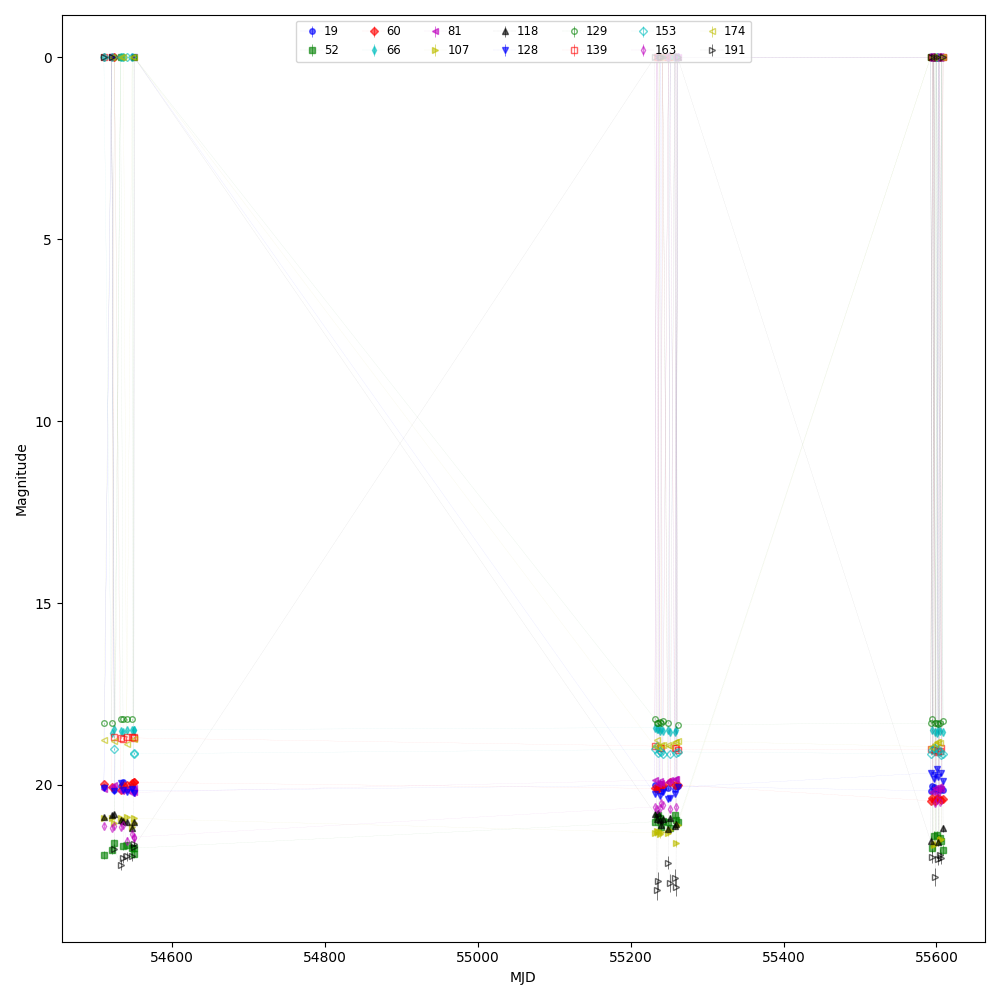

idx,time_start,time_delta,mag,mag_err,ul,sel
,d,s,,,,
0,54510.59375,1275.6500244140625,20.05954933166504,0.037015367299318314,18.353994369506836,True
1,54520.66015625,1166.6500244140625,0.0,0.0,18.130695343017578,True
2,54524.42578125,1065.5999755859375,20.125635147094727,0.037001851946115494,17.904199600219727,True
3,54532.5078125,1221.5999755859375,20.04068946838379,0.03399533033370972,18.245758056640625,True


In [5]:
rg_src_ids = rg.tt_sources[sel]["rg_src_id"][0:14]
fig_lc = plt.figure(figsize=(10, 10))
vvis.plot_light_curve(rg,rg_src_ids=rg_src_ids)
plt.tight_layout()
plt.show()
lcs = rg.get_light_curve(rg_src_ids=rg_src_ids)
lcs[rg_src_ids[0]][0:4].show_in_notebook()

Display the lightcurve info for some more selected sources

In [6]:
rg.ta_sources_lc[sel][0:2].show_in_notebook()

idx,fd_src_id,mag,mag_err,ul,time_bin_start,time_bin_size,field_id,rg_src_id
,,,,,d,s,,
0,19,[20.05955 0. 20.125635 20.04069 19.912304 20.112907 20.03194\n 20.102726 20.16471 20.006193 20.099844 20.089745 19.9853 20.17396\n 20.087082 20.087645 0. 20.122078 20.03694 20.035116 20.157976\n 20.038393 20.066216 20.109518 20.127005 0. 20.147915 20.083242\n 20.143024],[0.03701537 0. 0.03700185 0.03399533 0.03266081 0.03391747\n 0.0368081 0.03723254 0.03564352 0.0378229 0.04098009 0.04666338\n 0.0472771 0.04725816 0.04782284 0.04051124 0. 0.0377781\n 0.03884385 0.04371269 0.05705436 0.04593648 0.05014113 0.04492408\n 0.04856652 0. 0.04705551 0.04682399 0.04487884],[18.353994 18.130695 17.9042 18.245758 18.363676 18.394718 18.270094\n 18.19824 18.130589 17.551802 17.597439 17.278326 17.02131 17.057617\n 17.116014 17.761925 17.53826 17.89244 17.931963 17.42435 16.532663\n 16.926003 16.781382 17.087067 17.201674 17.549099 17.361164 17.602737\n 17.554636],[54510.594 54520.66 54524.426 54532.508 54536.273 54540.312 54547.57\n 54549.9 54550.17 55231.445 55233.844 55235.555 55237.68 55239.46\n 55241.652 55249.32 55251.508 55257.535 55259.176 55261.3 55592.395\n 55594.723 55596.707 55598.625 55600.543 55602.46 55604.375 55606.293\n 55608.62 ],[1275.65 1166.65 1065.6 1221.6 1280.6 1296.6 1233.55 1198.6 1166.6\n 925.5 942.55 829.6 748.55 759.5 777.45 1006.65 920.5 1060.6\n 1077.5 879.5 615.65 720.55 680.05 768.5 804.55 924.5 857.55\n 944.55 926.55],2604912508670050304,19
1,52,[21.923191 21.781008 21.581438 0. 21.684233 21.657148 21.741089\n 21.887394 21.73587 21.008694 20.878614 20.822283 20.91157 21.161034\n 20.979439 21.003107 21.193087 20.824844 20.9629 21.02343 0.\n 21.721073 21.392536 0. 21.363829 0. 21.461674 21.544327\n 21.783548],[0.11603764 0.11489796 0.10743604 0. 0.10457205 0.09923442\n 0.10330121 0.12529802 0.11314906 0.07856041 0.0709626 0.08027953\n 0.08180618 0.0942664 0.08748755 0.07454638 0.09132065 0.06371128\n 0.07052016 0.08414643 0. 0.13923563 0.11725857 0.\n 0.11035352 0. 0.11569052 0.10479004 0.13283068],[18.353994 18.130695 17.9042 18.245758 18.363676 18.394718 18.270094\n 18.19824 18.130589 17.551802 17.597439 17.278326 17.02131 17.057617\n 17.116014 17.761925 17.53826 17.89244 17.931963 17.42435 16.532663\n 16.926003 16.781382 17.087067 17.201674 17.549099 17.361164 17.602737\n 17.554636],[54510.594 54520.66 54524.426 54532.508 54536.273 54540.312 54547.57\n 54549.9 54550.17 55231.445 55233.844 55235.555 55237.68 55239.46\n 55241.652 55249.32 55251.508 55257.535 55259.176 55261.3 55592.395\n 55594.723 55596.707 55598.625 55600.543 55602.46 55604.375 55606.293\n 55608.62 ],[1275.65 1166.65 1065.6 1221.6 1280.6 1296.6 1233.55 1198.6 1166.6\n 925.5 942.55 829.6 748.55 759.5 777.45 1006.65 920.5 1060.6\n 1077.5 879.5 615.65 720.55 680.05 768.5 804.55 924.5 857.55\n 944.55 926.55],2604912508670050304,52


Look at sky of specific field

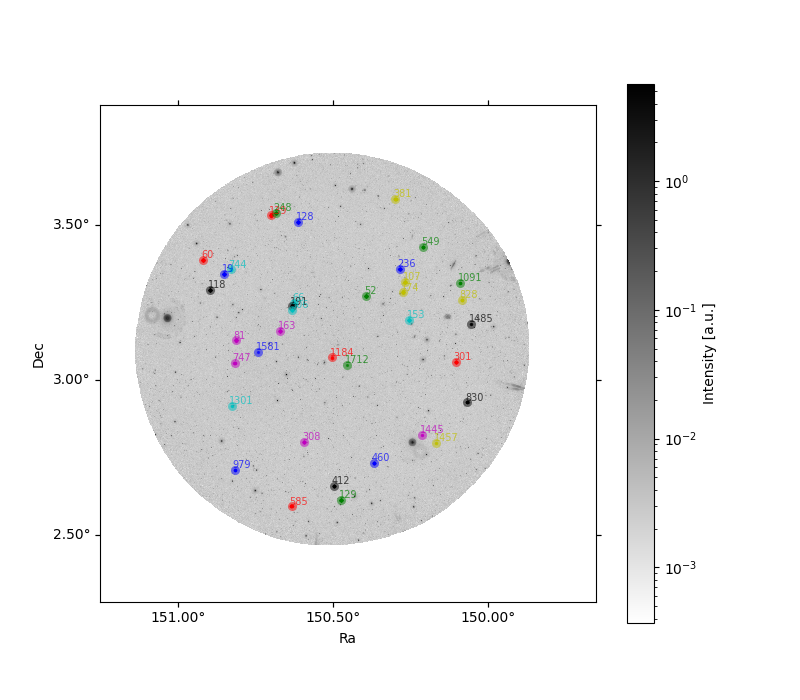

In [7]:
fd = BaseField()
fd.load_from_fits(field_fname)
fig_sky = vvis.plot_field_sky(fd,plot_detections=True)

Get coverage hp map and plot in sky

idx,pix_id,nr_vis,exp
0,94255763,29,27164.4
1,94255764,29,27164.4
2,94255765,29,27164.4
3,94272143,29,27164.4
4,94272144,29,27164.4
5,94272145,29,27164.4
6,94272146,29,27164.4
7,94272147,29,27164.4
8,94272148,29,27164.4
9,94272149,29,27164.4


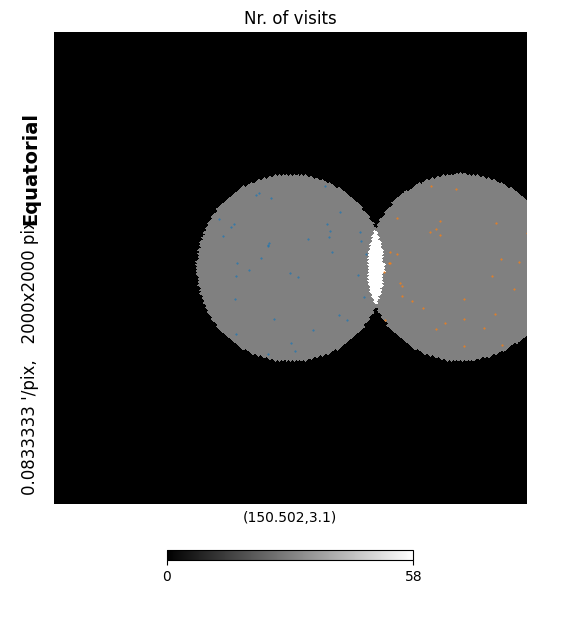

In [8]:
vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[0]["ra"],rg.tt_fields[1]["dec"])
rg.tt_coverage_hp[0:10].show_in_notebook()

Example of field plotting with jdviz.Imviz

In [9]:
from jdaviz import Imviz
from astropy.coordinates import SkyCoord
from astropy.table import Table

Plot sky image

In [10]:
imviz = Imviz()
viewer = imviz.default_viewer
imviz.load_data(field_fname, data_label='2529617952223789056')
imviz.show(loc='sidecar')

Show source and detection markers on-top

In [11]:
sel_det = fd.tt_detections["sel"]
tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
tt_srcs_sky = Table({'coord':srcs_sky })
viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')